In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import acquire
import split_scale
import features
import prep
import exploration
import feature_selection

## Acquire and summarize data

In [2]:
#data for baseline model. Includes square feet, number of bedrooms and number of bathrooms.
df = acquire.wrangle_zillow()

#### Data for tax rate distribution

In [3]:
df_tax = acquire.zillow_tax()

## Data prep

#### Clean up of df_tax and acquiring county names based on fips field
from:https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [4]:
df_tax = prep.tax_data_clean(df_tax)

#### Cleaning df data to only include selected features sqft, bedrooms, and bathrooms

In [5]:
df = prep.df_clean(df)

#### Basic statistical data for baseline model

In [6]:
df.describe()

,bathrooms,bedrooms,sqft,tax_value
count,15982.000000,15982.000000,15982.000000,1.598200e+04
mean,2.214992,3.252597,1836.581905,4.633691e+05
std,1.027066,0.950211,985.314844,6.435119e+05
min,1.000000,1.000000,320.000000,7.584000e+03
25%,2.000000,3.000000,1233.000000,1.817542e+05
50%,2.000000,3.000000,1592.000000,3.202605e+05
75%,3.000000,4.000000,2161.750000,5.287630e+05
max,20.000000,25.000000,26345.000000,1.912982e+07


#### Data dictionary

calculatedfinishedsquarefeet -  Used for sqft as it had the most consistent vales and fewest nulls. The few nulls that were left were excluded from the data as they were not significant enough in size to hurt our data.

bedroomcnt - Used for bedrooms over other available fields as it was the most consistently available field without nulls or zeros.

bathroomcnt - Used for bedrooms over other available fields as it was the most consistently available field without nulls or zeros.


Additionally houses with zero bedroom or bathrooms were excluded as these were determined to be eroneous with our dataset of single family residenial homes. Null tax values were also excluded. The data lost with these exclusions was minimal.

#### Distribution plots of 3 chosen baseline features

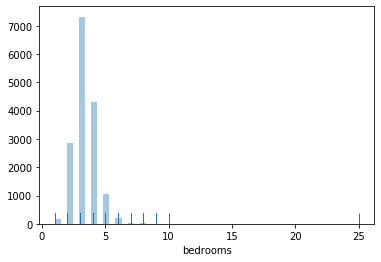

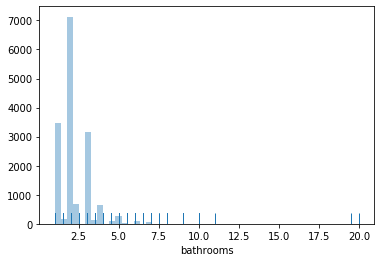

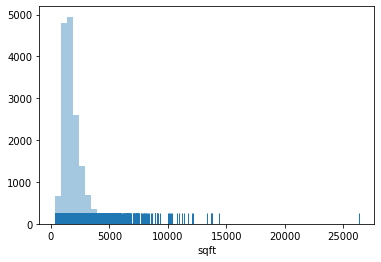

In [7]:
prep.distribution_plot(df)

#### Outliers

The plotted and statistical data showed that there are some extreme outliers in all three features. For this model I chose to keep all available data. In future models outliers will be handled after deeper analysis of the standard distribution

#### Scaling

The bedrooms and bathrooms are rough scaled equally. Square footage is in a significantly different unit of measure. To handle this we will be using standard scaling.

## Split and Scale

Data was split using an 80/20 train/test split set to randomstate 123

In [8]:
train,test,X_train,y_train,X_test,y_test,ols_model = split_scale.split_scale_df(df)

## Data exploration

#### Correlation Test

From the correlation plot of our three features we see that square footage has the strongest correlation with tax value. Bathrooms is also a strong indicator; while bathrooms is a fairly weak indcator.

Bathroom and bedroom are both strongly correlated with square feet. This is something that will be addressed in follow up modeling.

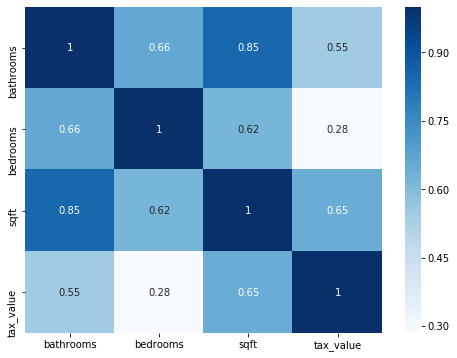

In [9]:
exploration.corr_plot(train)

#### R-squared, T Test, P Test and other key statistical measures



In [10]:
exploration.stats_test(y_train,X_train)

(Ttest_indResult(statistic=array([-4.04342365e-15]), pvalue=array([1.])),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                  OLS Regression Results                                
 Dep. Variable:              tax_value   R-squared (uncentered):                   0.445
 Model:                            OLS   Adj. R-squared (uncentered):              0.445
 Method:                 Least Squares   F-statistic:                              3412.
 Date:                Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
 Time:                        00:09:47   Log-Likelihood:                         -14381.
 No. Observations:               12785   AIC:                                  2.877e+04
 Df Residuals:                   12782   BIC:                                  2.879e+04
 Df Model:                           3                                                  
 Covariance Type:            nonrobust                                     

## Feature Engineering

After seeing the high correlation between bedrooms/bathrooms and square feet I decided to use the LassoCV embedded method to to score my three features for additional insight. Square feet came back as the strongest feature.

In [11]:
feature_selection.coef_lasso(y_train,X_train)

sqft         0.698312
bathrooms    0.095797
bedrooms    -0.212783
dtype: float64

For the initial model we will keep all three features. This gives us a current r2 value of .44

In [12]:
feature_selection.r2d2(y_train,train.yhat)

0.4447042156038722

## Modeling

After deciding to keep all three features for the initial MVP the residuals, SSE, RMSE, and MSE were all calculated